In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('poster')
sns.set_style('white')
%matplotlib inline

# Simulation Data

In systematically measuring genotype-phenotype data, how will the data be collected, stored and analyzed? Is a small laptop enough to model the fold change calculations locally? I explore this in the following notebook.

In [35]:
# Set n_genotypes > 1000 to obtain estimates of variance in error as a function of num_measurements
# Set n_genotypes < 15 to obtain diagnostic plots (traceplot) and comparison of modelled to actual.
# You've been forewarned - for the diagnostics and modelled, plotting with > 100 takes a while...
n_genotypes = 1000

means = np.random.randint(low=10, high=100, size=n_genotypes)
means = means * (means > 0)  # negative activities are not captured
sds = np.random.random(size=n_genotypes) * 30
num_measurements = np.random.randint(low=2, high=5, size=n_genotypes)

# Create simulated data.
data = []
indices = []

for i in range(n_genotypes):
    n = num_measurements[i]
    mean = means[i]
    sd = sds[i]
    
    measurements = np.random.normal(loc=mean, scale=sd, size=n)
    # print(measurements)
    measurements = measurements * (measurements > 0)
    # print(measurements)
    
    data.extend(measurements.tolist())
    indices.extend([i] * n)

# Add baseline measurements (bl_measures)
n_bl_measures = 2
bl_measures = np.random.normal(loc=1.0, scale=0.1, size=n_bl_measures)
bl_measures = bl_measures * (bl_measures > 0)
data.extend(bl_measures)
indices.extend([n_genotypes] * n_bl_measures)
num_measurements = np.append(num_measurements, n_bl_measures)
means = np.append(means, bl_measures.mean())
sds = np.append(sds, bl_measures.std())

# Add pos_ctrl measurements (pc_measures)
n_pc_measures = 10
pc_measures = np.random.normal(loc=20.0, scale=2, size=n_pc_measures)
pc_measures = pc_measures * (pc_measures > 0)
data.extend(pc_measures)
indices.extend([n_genotypes + 1] * n_pc_measures)
num_measurements = np.append(num_measurements, n_pc_measures)
means = np.append(means, pc_measures.mean())
sds = np.append(sds, pc_measures.std())

# convert indices to a numpy array
indices = np.array(indices)

In [36]:
indices

array([   0,    0,    0, ..., 1001, 1001, 1001])

In [37]:
means

array([ 42.        ,  65.        ,  29.        , ...,  62.        ,
         0.99585532,  20.16482039])

In [38]:
sds

array([  4.02525017,  27.50944721,  26.35229427, ...,   3.185372  ,
         0.0841317 ,   1.22980279])

In [39]:
num_measurements

array([ 3,  2,  4, ...,  3,  2, 10])

In [40]:
len(data), len(indices)

(3032, 3032)

In [41]:
np.array(data)

array([ 37.98437548,  36.5187167 ,  36.01393404, ...,  21.98449716,
        18.43500235,  20.03997742])

In [42]:
zp_det = 1 - (3 * sds[-2] + 3 * sds[-1]) / np.abs(means[-2] - means[-1])
zp_det

0.79436534878184395

In [43]:
with pm.Model() as model:
    # Hyperpriors
    # fold_mu = pm.Flat('fold_mu')
    # fold_sd = pm.HalfCauchy('fold_sd', 100)
    # fold_alpha = pm.Flat('fold_alpha')
    # fold_beta = pm.Flat('fold_beta')
    # fold_tau = pm.Exponential('fold_tau', lam=10)
    # fold_lam = pm.Beta('fold_lam', alpha=10, beta=1)

    # "Intercept", which is basically the measurement values.
    # fold = pm.Gamma('fold', alpha=1, beta=2, shape=n_genotypes+1)
    # fold = pm.HalfNormal('fold', tau=fold_tau, shape=n_genotypes+2)
    # fold = pm.Exponential('fold', lam=fold_lam, shape=n_genotypes+2)
    upper = pm.Exponential('upper', lam=0.5)
    fold = pm.Uniform('fold', lower=1E-9, upper=upper, shape=n_genotypes+2)
    
    # Assume that data have heteroskedastic (i.e. variable) error but are drawn from the same distribution
    sigma = pm.Gamma('sigma', alpha=1, beta=1, shape=n_genotypes+2)
    
    # Model prediction
    mu = fold[indices]
    sig = sigma[indices]
    
    # Data likelihood
    like = pm.Normal('like', mu=mu, sd=sig, observed=data)
    
    # Compute Z-factors relative to positive ctrl.
    z_factor = pm.Deterministic('z_factor', 1 - (3 * sigma[:-1] + 3 * sigma[-1]) / np.abs(fold[:-1] - fold[-1]))
    
    # Compute Z-prime factor between negative and positive control.
    zp_factor = pm.Deterministic('zp_factor', 1 - (3 * sigma[-2] + 3 * sigma[-1]) / np.abs(fold[-2] - fold[-1]))
    
    # Compute fold changes
    fold_changes = pm.Deterministic('fold_changes', fold[:-2] / fold[-1])

Applied log-transform to upper and added transformed upper_log_ to model.
Applied interval-transform to fold and added transformed fold_interval_ to model.
Applied log-transform to sigma and added transformed sigma_log_ to model.


In [44]:
%%time
with model:
    if n_genotypes <= 10:
        n_steps = 150000
    elif n_genotypes > 10:
        n_steps = 200000
    params = pm.variational.advi(n=n_steps)
    trace = pm.variational.sample_vp(params, draws=2000)

Iteration 0 [0%]: ELBO = -38668244.28
Iteration 20000 [10%]: Average ELBO = -2894194.43
Iteration 40000 [20%]: Average ELBO = -36366.74
Iteration 60000 [30%]: Average ELBO = -21409.37
Iteration 80000 [40%]: Average ELBO = -19128.07
Iteration 100000 [50%]: Average ELBO = -18724.03
Iteration 120000 [60%]: Average ELBO = -18609.43
Iteration 140000 [70%]: Average ELBO = -18574.46
Iteration 160000 [80%]: Average ELBO = -18558.6
Iteration 180000 [90%]: Average ELBO = -18550.25
Finished [100%]: Average ELBO = -18549.24
CPU times: user 2min 4s, sys: 439 ms, total: 2min 4s
Wall time: 2min 5s


In [45]:
if n_genotypes <= 15:
    fig = plt.figure()
    pm.traceplot(trace, varnames=['upper'])
    
    fig = plt.figure()
    pm.forestplot(trace, vline=1, varnames=['fold'])
    
    fig = plt.figure()
    pm.forestplot(trace, varnames=['z_factor'], xrange=(-1, 1), vline=0.5)
    
    fig = plt.figure()
    pm.forestplot(trace, varnames=['sigma'])
    
    plt.figure()
    pm.forestplot(trace, varnames=['fold_changes'], vline=1)

In [46]:
# plt.figure()
# pm.forestplot(trace, varnames=['fold_lam'])
# plt.figure()
# pm.traceplot(trace, varnames=['fold_lam'])

In [47]:
if n_genotypes <= 15:
    pm.summary(trace)

In [48]:
if n_genotypes <= 15:
    pm.traceplot(trace)

# Error in Estimated Mean

What is the error in estimated mean as a function of the number of measurements?

In [49]:
num_measurements

array([ 3,  2,  4, ...,  3,  2, 10])

In [50]:
trace['fold'].mean(axis=0) - means

array([ -5.13910756e+00,  -2.45090110e+01,   1.80444713e+00, ...,
        -1.38854975e-01,   1.82419926e-02,   2.38368586e-02])

In [51]:
import pandas as pd
errors_df = pd.DataFrame([num_measurements, (trace['fold'].mean(axis=0) - means)]).T
errors_df.columns = ['num_measurements', 'error_means']
errors_df.head()

,num_measurements,error_means
0,3.0,-5.139108
1,2.0,-24.509011
2,4.0,1.804447
3,2.0,2.677937
4,2.0,-8.319360


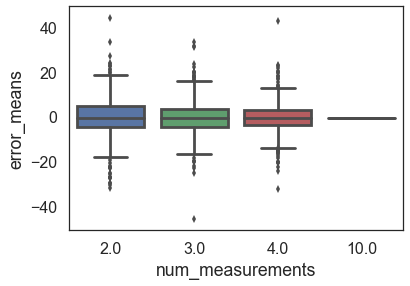

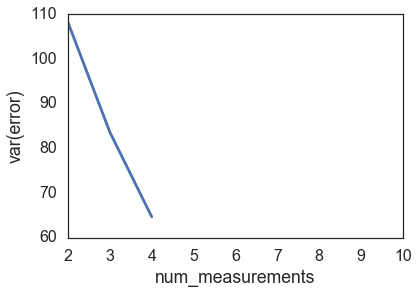

In [52]:
if n_genotypes >= 500:
    sns.boxplot(data=errors_df, x='num_measurements', y='error_means')
    errors_df.groupby('num_measurements').var().plot(legend=False)
    plt.ylabel('var(error)')

In [53]:
(trace['fold'].mean(axis=0) - means).mean()

0.23043292450856404

In [54]:
if n_genotypes <= 15:
    plt.figure()
    pm.traceplot(trace, varnames=['fold'])
    plt.figure()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1273ec278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1278b3198>]], dtype=object)

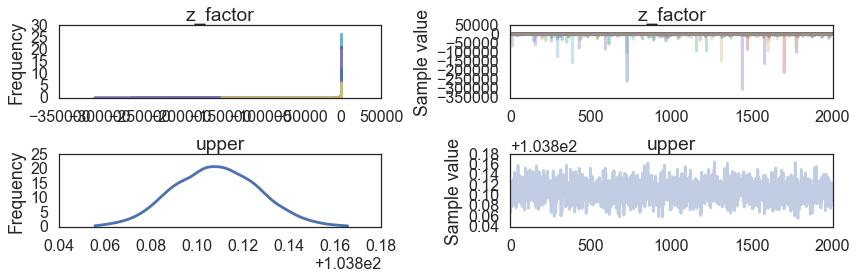

In [64]:
pm.traceplot(trace, varnames=['z_factor', 'upper'])

# Compare modelled to actual

In [55]:
trace['fold'].mean(axis=0)

array([ 36.86089244,  40.49098897,  30.80444713, ...,  61.86114502,
         1.01409731,  20.18865725])

In [56]:
trace['fold'].mean(axis=0).shape

(1002,)

In [57]:
np.arange(1, n_genotypes+3).shape

(1002,)

In [58]:
if n_genotypes <= 15:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    lower = trace['fold'].mean(axis=0) - np.percentile(trace['fold'], 2.5, axis=0)
    upper = np.percentile(trace['fold'], 97.5, axis=0) - trace['fold'].mean(axis=0)
    yerr_pos = [lower, upper]
    ax.errorbar(x=np.arange(1, n_genotypes+3), y=trace['fold'].mean(axis=0), 
                # y-error bars
                yerr=yerr_pos,
                # styling
                color='blue', ls='none', alpha=0.5, label='modeled',)
    ax.scatter(x=np.arange(1, n_genotypes+3), y=means, 
               # styling
               color=['red'] * (n_genotypes) + ['green'] + ['blue'], marker='o', s=100, label='true mean',)
    ax.errorbar(x=np.arange(1, n_genotypes+3), y=means,
               yerr=sds,
               color='red', ls='none', alpha=0.5, label='true var')
    ax.legend(loc='upper left', frameon=False)
    ax.hlines(xmin=0, xmax=n_genotypes+3, y=trace['fold'].mean(axis=0)[-2], linestyles='--', alpha=0.2)
    ax.hlines(xmin=0, xmax=n_genotypes+3, y=trace['fold'].mean(axis=0)[-1], alpha=0.2)
    ax.set_xlabel('genotype ID')
    ax.set_ylabel('fold change')
    # ax.set_xlim(, n_genotypes+2)

In [59]:
if n_genotypes <= 15:
    fig = plt.figure()
    pm.forestplot(trace, vline=1, varnames=['fold'])
print('just for checking the above plot...')

just for checking the above plot...


How does Z-factor vary as a function of variance for a fixed set of replicate measurements?

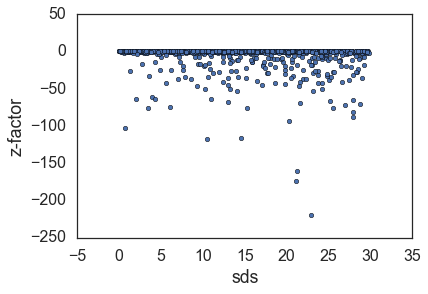

In [60]:
df = pd.DataFrame()
df['z-factor'] = trace['z_factor'].mean(axis=0)
df['num_measurements'] = num_measurements[:-1]
df['sds'] = sds[:-1]

df.plot(kind='scatter', x='sds', y='z-factor')

In [61]:
num_measurements.shape

(1002,)

In [62]:
trace['z_factor'].shape

(2000, 1001)